# Project: Investigation of No Show Appointments Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> The no show appointment dataset contains information regarding over 100k medical appointments made in Brazil, where each record holds one patient's description, characteristics and whether he/she visited the doctor(s) at the appointed time or not. 

__Description of the Column Names__:
- `PatientId`: The id number of one patient
- `AppointmentID`: The id number of one appointment
- `Gender`: This indicates whether the patient is a male or a female
- `DataMarcacaoConsulta / AppointmentDay`: The date of the medical appointment
- `DataAgendamento / ScheduledDay`: The date when the patient registers an appointment
- `Age`: The age of the patient
- `Neighbourhood`: The location of the appointment
- `Scholarship`: A boolean indication describing whether the patient is a recipient of the [Bolsa Familia Aid Program](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia) (`True`) or not (`False`)
- `Hipertension`: A boolean indication describing the blood pressure of a patient in the long term as high if `True` and low if `False`
- `Diabetes`: A boolean indication describing whether the patient suffers from diabetes (`True`) or not (`False`)
- `Alcoholism`: A boolean indication desribing whether the patient is an alcoholic (`True`) or not (`False`)
- `Handcap`: A categorical measure of handicaps with a domain equivalent to [0, 1, 2, 3, 4]
- `SMS_received`: The number of messages sent to the patient
- `No-show`: A boolean indication describing whether the patient visited the doctor(s) on the appointed date (`True`) or not (`False`)


### Questions:
> __Important Notice__
>
> The analysis within this notebook is partially based on the assumption that entries under `scheduled_day` and `appointment_day` which have same date are registered and intended to be fulfilled on the same day. This assumption was made due to the fact that the time portion of all the entries under `appointment_day` was missing. 

- Does the waiting time between registration and the actual appointment date influence the number of no-shows?
- Are scholarship recipients more likely to visit the doctor(s) on their appointment dates?
- How does alcohol consumption affect the number of no-shows in various medical centers?

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

## Gather 
> Read in the dataset from a .csv file

In [2]:
no_show_appointments = pd.read_csv('no-show-appointments.csv')

## Assess
> Visual assessment
>
> Programmatic assessment

In [3]:
no_show_appointments.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
no_show_appointments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
no_show_appointments.sample(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
83749,4.323166e+14,5668893,M,2016-05-06T09:54:59Z,2016-05-06T00:00:00Z,57,JARDIM CAMBURI,0,0,0,0,0,0,No
76877,5.613729e+13,5664604,F,2016-05-05T12:59:51Z,2016-05-10T00:00:00Z,15,SÃO PEDRO,0,0,0,0,0,1,Yes
73091,9.636647e+14,5643724,M,2016-05-02T07:48:19Z,2016-05-04T00:00:00Z,40,ITARARÉ,0,0,0,0,0,0,Yes
104227,6.372674e+12,5665944,F,2016-05-05T15:37:15Z,2016-06-07T00:00:00Z,19,GURIGICA,0,0,0,0,0,1,No
110059,2.871122e+10,5775326,F,2016-06-06T09:17:30Z,2016-06-08T00:00:00Z,50,JOANA D´ARC,0,1,0,0,0,0,No
90972,1.269837e+12,5750366,F,2016-05-31T08:47:42Z,2016-06-08T00:00:00Z,17,TABUAZEIRO,0,0,0,0,0,0,No
30800,7.875688e+11,5690454,F,2016-05-12T10:04:26Z,2016-05-31T00:00:00Z,38,SANTA CLARA,0,0,0,0,0,1,Yes
624,7.113874e+13,5634080,M,2016-04-28T10:21:19Z,2016-04-29T00:00:00Z,56,CENTRO,0,1,0,0,0,0,No
43742,3.476438e+13,5657597,M,2016-05-04T09:37:37Z,2016-05-04T00:00:00Z,35,GURIGICA,0,0,0,0,0,0,No
94889,4.147887e+12,5755645,F,2016-06-01T07:33:33Z,2016-06-01T00:00:00Z,65,ILHA DO PRÍNCIPE,0,1,1,0,0,0,No


In [6]:
no_show_appointments.shape

(110527, 14)

In [7]:
no_show_appointments.duplicated().sum()

0

In [8]:
no_show_appointments.AppointmentID.duplicated().sum()

0

In [9]:
no_show_appointments.Neighbourhood.value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64

In [10]:
no_show_appointments.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [11]:
no_show_appointments.query('Age < 0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [12]:
no_show_appointments.iloc[99832]['PatientId']

465943158731293.0

In [13]:
no_show_appointments.query('PatientId == 465943158731293.0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [14]:
no_show_appointments.query('Age > 100')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
58014,9.762948e+14,5651757,F,2016-05-03T09:14:53Z,2016-05-03T00:00:00Z,102,CONQUISTA,0,0,0,0,0,0,No
63912,3.196321e+13,5700278,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,3.196321e+13,5700279,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,3.196321e+13,5562812,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
90372,2.342836e+11,5751563,F,2016-05-31T10:19:49Z,2016-06-02T00:00:00Z,102,MARIA ORTIZ,0,0,0,0,0,0,No
97666,7.482346e+14,5717451,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No


### Tidiness Issues:

_No tidiness issues were detected_

### Quality Issues:
1. `Hypertension` column name misspelled as `Hipertension`
2. `Handicap` column name misspelled as `Handcap`
3. Inconsistent capitalization of column names
4. Entry 99832 holds a negative value for the `Age` column
5. Boolean values in `[Scholarship, Hipertension, Diabetes, Alcoholism]` misrepresented as 1s and 0s
6. `Handcap` misrepresented as being of type int but it should not be used for any calculation
7. Boolean values in `No-show` misrepresented as _Yes_ and _No_
8. `No-show` misrepresented as being of type object (string)

__Edit: Issue No. 8__
- Fixing issue no. 7 changed the type to int
9. `PatientId` misrepresented as being of type float but it should not be used for any calculation
10. `PatientId` has a redundant '.0' trailing all values
11. `AppointmentID` misrepresented as being of type int but it should not be used for any calculation
12. `Gender` misrepresented as being of type object (string)
13. Types of `[Scholarship, Hipertension, Diabetes, Alcoholism]` misrepresented ints

__Edit: Issue No. 13__
- Fixing issue no. 5 automatically converted the dtypes of the specified columns to bool
14. `ScheduledDay` and `AppointmentDay` misrepresented as being of type object (string)
15. `ScheduledDay` is ahead of `AppointmentDay` for some records

__Edit: Issue No. 15__

- Five appointments were registered after the appointment date; specifically records [27033, 55226, 64175, 71533, 72362]

## Clean

In [15]:
# Create a copy of the original dataset to start cleaning without modifying the original information
no_show_appointments_clean = no_show_appointments.copy()

*Hypertension column name misspelled as Hipertension*
### Define 
- Rename the column `Hipertension` to `Hypertension`

### Code

In [16]:
no_show_appointments_clean.rename(columns={'Hipertension': 'Hypertension'}, inplace=True)

### Test

In [17]:
no_show_appointments_clean.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

*Handicap column name misspelled as Handcap*
### Define
- Rename the column `Handcap` to `Handicap`

### Code

In [18]:
no_show_appointments_clean.rename(columns={'Handcap': 'Handicap'}, inplace=True)

### Test

In [19]:
no_show_appointments_clean.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'No-show'],
      dtype='object')

*Inconsistent capitalization of column names*
### Define
- Reformat all column name according to the snake case conventions

### Code

In [20]:
new_columns = ['patient_id', 'appointment_id', 'gender', 'scheduled_day', 'appointment_day', 'age', 'neighbourhood',
               'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received', 'no_show']
no_show_appointments_clean.columns = new_columns

### Test

In [21]:
no_show_appointments_clean.columns

Index(['patient_id', 'appointment_id', 'gender', 'scheduled_day',
       'appointment_day', 'age', 'neighbourhood', 'scholarship',
       'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received',
       'no_show'],
      dtype='object')

*Entry 99832 holds a negative value for the Age column*
### Define
- Drop entry 99832

### Code

In [22]:
no_show_appointments_clean.drop(99832, inplace=True)

### Test

In [23]:
no_show_appointments_clean.query('age < 0')

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show


*Boolean values in [Scholarship, Hipertension, Diabetes, Alcoholism, Handcap] misrepresented as 1s and 0s*
### Define
- Replace 1s with boolean True and 0s with boolean False 

### Code

In [24]:
target_columns = ['scholarship', 'hypertension', 'diabetes', 'alcoholism']

for column in target_columns:
    no_show_appointments_clean[column].replace([0, 1], [False, True], inplace=True)

### Test

In [25]:
no_show_appointments_clean.scholarship.value_counts()

False    99665
True     10861
Name: scholarship, dtype: int64

In [26]:
no_show_appointments_clean.hypertension.value_counts()

False    88725
True     21801
Name: hypertension, dtype: int64

In [27]:
no_show_appointments_clean.diabetes.value_counts()

False    102583
True       7943
Name: diabetes, dtype: int64

In [28]:
no_show_appointments_clean.alcoholism.value_counts()

False    107166
True       3360
Name: alcoholism, dtype: int64

*Handcap misrepresented as being of type int but it should not be used for any calculation*
### Define
- Use astype to change the type of `handicap` column to category

### Code

In [29]:
no_show_appointments_clean.handicap = no_show_appointments_clean.handicap.astype('category')

### Test

In [30]:
no_show_appointments_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   patient_id       110526 non-null  float64 
 1   appointment_id   110526 non-null  int64   
 2   gender           110526 non-null  object  
 3   scheduled_day    110526 non-null  object  
 4   appointment_day  110526 non-null  object  
 5   age              110526 non-null  int64   
 6   neighbourhood    110526 non-null  object  
 7   scholarship      110526 non-null  bool    
 8   hypertension     110526 non-null  bool    
 9   diabetes         110526 non-null  bool    
 10  alcoholism       110526 non-null  bool    
 11  handicap         110526 non-null  category
 12  sms_received     110526 non-null  int64   
 13  no_show          110526 non-null  object  
dtypes: bool(4), category(1), float64(1), int64(3), object(5)
memory usage: 9.0+ MB


*Boolean values in No-show misrepresented as Yes and No*
### Define
- Replace all 'Yes' values with boolean True and all 'No' values with boolean False in `no_show` column

### Code

In [31]:
no_show_appointments_clean.no_show.replace(['Yes', 'No'], [True, False], inplace=True)

### Test

In [32]:
no_show_appointments_clean.no_show.value_counts()

False    88207
True     22319
Name: no_show, dtype: int64

*No-show misrepresented as being of type object (string)*

*Edit: Issue No. 8*

*Fixing issue no. 7 changed the type to int*

### Define
- Use astype to change the type of `no_show` column to bool

### Code

In [33]:
no_show_appointments_clean.no_show = no_show_appointments_clean.no_show.astype(bool)

### Test

In [34]:
no_show_appointments_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   patient_id       110526 non-null  float64 
 1   appointment_id   110526 non-null  int64   
 2   gender           110526 non-null  object  
 3   scheduled_day    110526 non-null  object  
 4   appointment_day  110526 non-null  object  
 5   age              110526 non-null  int64   
 6   neighbourhood    110526 non-null  object  
 7   scholarship      110526 non-null  bool    
 8   hypertension     110526 non-null  bool    
 9   diabetes         110526 non-null  bool    
 10  alcoholism       110526 non-null  bool    
 11  handicap         110526 non-null  category
 12  sms_received     110526 non-null  int64   
 13  no_show          110526 non-null  bool    
dtypes: bool(5), category(1), float64(1), int64(3), object(4)
memory usage: 8.2+ MB


*PatientId misrepresented as being of type float but it should not be used for any calculation*
### Define
- Use astype to change the type of `patient_id` to string

### Code

In [35]:
no_show_appointments_clean.patient_id = no_show_appointments_clean.patient_id.astype(str)

### Test

In [36]:
no_show_appointments_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   patient_id       110526 non-null  object  
 1   appointment_id   110526 non-null  int64   
 2   gender           110526 non-null  object  
 3   scheduled_day    110526 non-null  object  
 4   appointment_day  110526 non-null  object  
 5   age              110526 non-null  int64   
 6   neighbourhood    110526 non-null  object  
 7   scholarship      110526 non-null  bool    
 8   hypertension     110526 non-null  bool    
 9   diabetes         110526 non-null  bool    
 10  alcoholism       110526 non-null  bool    
 11  handicap         110526 non-null  category
 12  sms_received     110526 non-null  int64   
 13  no_show          110526 non-null  bool    
dtypes: bool(5), category(1), int64(3), object(5)
memory usage: 8.2+ MB


In [37]:
no_show_appointments_clean.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296.0,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,False,True,False,False,0,0,False
1,558997776694438.0,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,False,False,False,False,0,0,False
2,4262962299951.0,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,False,False,False,False,0,0,False
3,867951213174.0,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,False,False,False,False,0,0,False
4,8841186448183.0,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,False,True,True,False,0,0,False


*PatientId has a redundant '.0' trailing all values*
### Define 
- Use rstrip to remove all trailing '.0' from the `patient_id` column

### Code

In [38]:
no_show_appointments_clean.patient_id = no_show_appointments_clean.patient_id.str.rstrip('.0')

### Test

In [39]:
no_show_appointments_clean.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,False,True,False,False,0,0,False
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,False,False,False,False,0,0,False
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,False,False,False,False,0,0,False
3,867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,False,False,False,False,0,0,False
4,8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,False,True,True,False,0,0,False


*AppointmentID misrepresented as being of type int but it should not be used for any calculation*
### Define
- Use astype to change the type of `appointment_id` to string

### Code

In [40]:
no_show_appointments_clean.appointment_id = no_show_appointments_clean.appointment_id.astype(str)

### Test

In [41]:
no_show_appointments_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   patient_id       110526 non-null  object  
 1   appointment_id   110526 non-null  object  
 2   gender           110526 non-null  object  
 3   scheduled_day    110526 non-null  object  
 4   appointment_day  110526 non-null  object  
 5   age              110526 non-null  int64   
 6   neighbourhood    110526 non-null  object  
 7   scholarship      110526 non-null  bool    
 8   hypertension     110526 non-null  bool    
 9   diabetes         110526 non-null  bool    
 10  alcoholism       110526 non-null  bool    
 11  handicap         110526 non-null  category
 12  sms_received     110526 non-null  int64   
 13  no_show          110526 non-null  bool    
dtypes: bool(5), category(1), int64(2), object(6)
memory usage: 8.2+ MB


*Gender misrepresented as being of type object (string)*
### Define
- Use astype to change the type of `gender` to category

### Code

In [42]:
no_show_appointments_clean.gender = no_show_appointments_clean.gender.astype('category')

### Test

In [43]:
no_show_appointments_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   patient_id       110526 non-null  object  
 1   appointment_id   110526 non-null  object  
 2   gender           110526 non-null  category
 3   scheduled_day    110526 non-null  object  
 4   appointment_day  110526 non-null  object  
 5   age              110526 non-null  int64   
 6   neighbourhood    110526 non-null  object  
 7   scholarship      110526 non-null  bool    
 8   hypertension     110526 non-null  bool    
 9   diabetes         110526 non-null  bool    
 10  alcoholism       110526 non-null  bool    
 11  handicap         110526 non-null  category
 12  sms_received     110526 non-null  int64   
 13  no_show          110526 non-null  bool    
dtypes: bool(5), category(2), int64(2), object(5)
memory usage: 7.5+ MB


*ScheduledDay and AppointmentDay misrepresented as being of type object (string)*
### Define
- Use to_datetime to change the types of both columns to datetime

### Code

In [44]:
no_show_appointments_clean.scheduled_day = pd.to_datetime(no_show_appointments_clean.scheduled_day)
no_show_appointments_clean.appointment_day = pd.to_datetime(no_show_appointments_clean.appointment_day)

### Test

In [45]:
no_show_appointments_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   patient_id       110526 non-null  object             
 1   appointment_id   110526 non-null  object             
 2   gender           110526 non-null  category           
 3   scheduled_day    110526 non-null  datetime64[ns, UTC]
 4   appointment_day  110526 non-null  datetime64[ns, UTC]
 5   age              110526 non-null  int64              
 6   neighbourhood    110526 non-null  object             
 7   scholarship      110526 non-null  bool               
 8   hypertension     110526 non-null  bool               
 9   diabetes         110526 non-null  bool               
 10  alcoholism       110526 non-null  bool               
 11  handicap         110526 non-null  category           
 12  sms_received     110526 non-null  int64              
 13 

In [46]:
no_show_appointments_clean.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,False,True,False,False,0,0,False
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,False,False,False,0,0,False
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,False,False,False,False,0,0,False
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,False,False,False,False,0,0,False
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,True,True,False,0,0,False


*ScheduledDay is ahead of AppointmentDay for some records*

*Edit: Issue No. 15*

*Five appointments were registered after the appointment date; specifically records [27033, 55226, 64175, 71533, 72362]*
### Define
- Drop the rows where the difference is < -1 days ( Appointments where the difference is -1 days or less than that are assumed to have been registered and will be attended in the same day)

### Code
> As opposed to all other 'Code' segments, this segment will include a small __Assess__ segment that could not have been included in the main __Assess__ section because the columns `scheduled_day` and `appointment_day` had to have their dtypes corrected first (object -> datetime)

In [47]:
difference = no_show_appointments_clean.appointment_day - no_show_appointments_clean.scheduled_day
mask = (difference.dt.days*24 + difference.dt.seconds/3600) < 0
no_show_appointments_clean[mask]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,False,True,False,False,0,0,False
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,False,False,False,0,0,False
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,False,False,False,False,0,0,False
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,False,False,False,False,0,0,False
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,True,True,False,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110511,823599626588,5786742,F,2016-06-08 08:50:20+00:00,2016-06-08 00:00:00+00:00,14,MARIA ORTIZ,False,False,False,False,0,0,False
110512,98762456447375,5786368,F,2016-06-08 08:20:01+00:00,2016-06-08 00:00:00+00:00,41,MARIA ORTIZ,False,False,False,False,0,0,False
110513,86747784995281,5785964,M,2016-06-08 07:52:55+00:00,2016-06-08 00:00:00+00:00,2,ANTÔNIO HONÓRIO,False,False,False,False,0,0,False
110514,2695685177138,5786567,F,2016-06-08 08:35:31+00:00,2016-06-08 00:00:00+00:00,58,MARIA ORTIZ,False,False,False,False,0,0,False


In [48]:
# How many, if any, of the 38567 rows have a difference of < -1 days ?
second_mask = difference.dt.days < -1
no_show_appointments_clean[second_mask]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
27033,7839272661752,5679978,M,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,False,False,False,False,1,0,True
55226,7896293967868,5715660,F,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,False,False,False,False,1,0,True
64175,24252258389979,5664962,F,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,False,False,False,False,0,0,True
71533,998231581612122,5686628,F,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,False,False,False,False,0,0,True
72362,3787481966821,5655637,M,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,False,False,False,False,0,0,True


In [49]:
no_show_appointments_clean.drop([27033, 55226, 64175, 71533, 72362], inplace=True)

### Test

In [50]:
difference_2 = no_show_appointments_clean.appointment_day - no_show_appointments_clean.scheduled_day
no_show_appointments_clean[difference_2.dt.days < -1]

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show


## Save clean dataset 

In [51]:
no_show_appointments_clean.to_csv('no_show_appointments_clean.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis

> Represent the proportion of no-shows as a reference of the dependent variable for all questions.

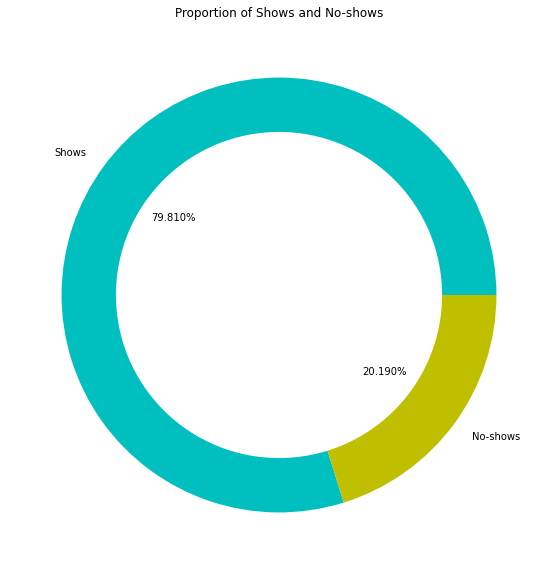

In [52]:
total = no_show_appointments_clean.shape[0]
shows = no_show_appointments_clean[no_show_appointments_clean.no_show == False].shape[0]
no_shows = no_show_appointments_clean[no_show_appointments_clean.no_show == True].shape[0]
shows_prop = shows/total
no_shows_prop = no_shows/total

plt.figure(figsize=(10,10))
plt.pie([shows_prop, no_shows_prop], labels=['Shows', 'No-shows'], colors=['c', 'y'], autopct='%1.3f%%');
plt.title('Proportion of Shows and No-shows')
circle = plt.Circle(xy=(0,0), radius=0.75, facecolor='white')
plt.gca().add_artist(circle);

### Does the waiting time between registration and the actual appointment date influence the number of no-shows?

In [53]:
diff_viz = no_show_appointments_clean.appointment_day - no_show_appointments_clean.scheduled_day
diff_viz_regular = diff_viz.dt.days*24 + diff_viz.dt.seconds/3600

# patients who register their appointments in the same day will presumably wait for the remaining time of that day at maximum 
def regulate(number):
    if number < 0:
        return 24 + number
    else:
        return number
    
diff_viz_regular = diff_viz_regular.apply(regulate)

In [54]:
# Find the average waiting period
average = diff_viz_regular.mean()
frac, hours = math.modf(average)
f, days = math.modf(hours/24)
frac2, minu = math.modf(frac*60)
print('The average waiting time is {} day(s) {} hour(s) {} minute(s) {} second(s).'.format(int(days), int(hours - days*24), int(minu), math.ceil(frac2*60)))

The average waiting time is 10 day(s) 1 hour(s) 31 minute(s) 56 second(s).


In [55]:
frame = {'waiting_times': diff_viz_regular, 'no_show': no_show_appointments_clean.no_show}
df = pd.DataFrame(frame)

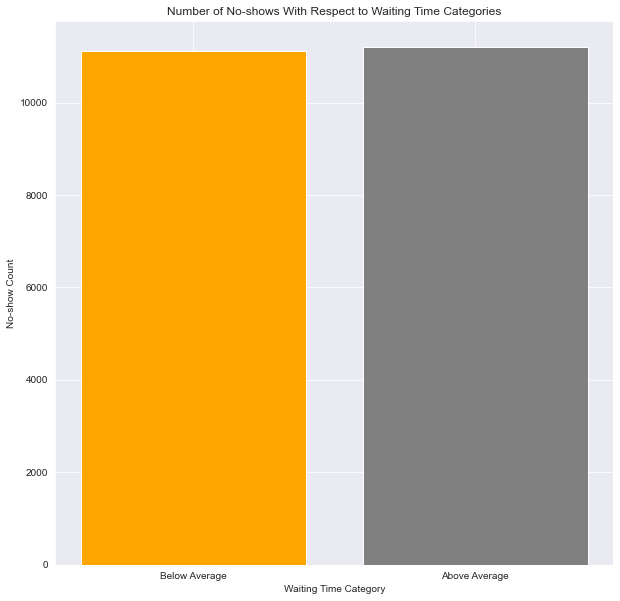

In [56]:
above_average = df[(df.waiting_times > average) & (df.no_show == True)].shape[0]
below_average = df[(df.waiting_times < average) & (df.no_show == True)].shape[0]

sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
plt.title('Number of No-shows With Respect to Waiting Time Categories')
plt.xlabel('Waiting Time Category')
plt.ylabel('No-show Count')
plt.bar([2, 3], [below_average, above_average], tick_label=['Below Average', 'Above Average'], color=['orange', 'gray']);

In [57]:
print('The number of no-shows for the below average waiting time category is {}. \nThe number of no-shows for the above average waiting time category is {}.'.format(below_average, above_average))

The number of no-shows for the below average waiting time category is 11114. 
The number of no-shows for the above average waiting time category is 11200.


### Discussion
> The fact that there is a very small increment in the number of no-show patients for the above average waiting time category is slightly visible in the bar chart above, however it is definitely not enough to conclude that there is a relation between both the `no_show` variable and the `waiting_time` varriable which was synthesized using `appointment_day` and `scheduled_day` variables in the clean dataset. In fact, because the count difference (11200 - 11114 = 86) for both waiting time categories is very small we may assume that waiting times do not play a very important role in predicting whether a given patient will make it to his/her scheduled appointment.

### Are scholarship recipients more likely to visit the doctor(s) on their appointment dates?

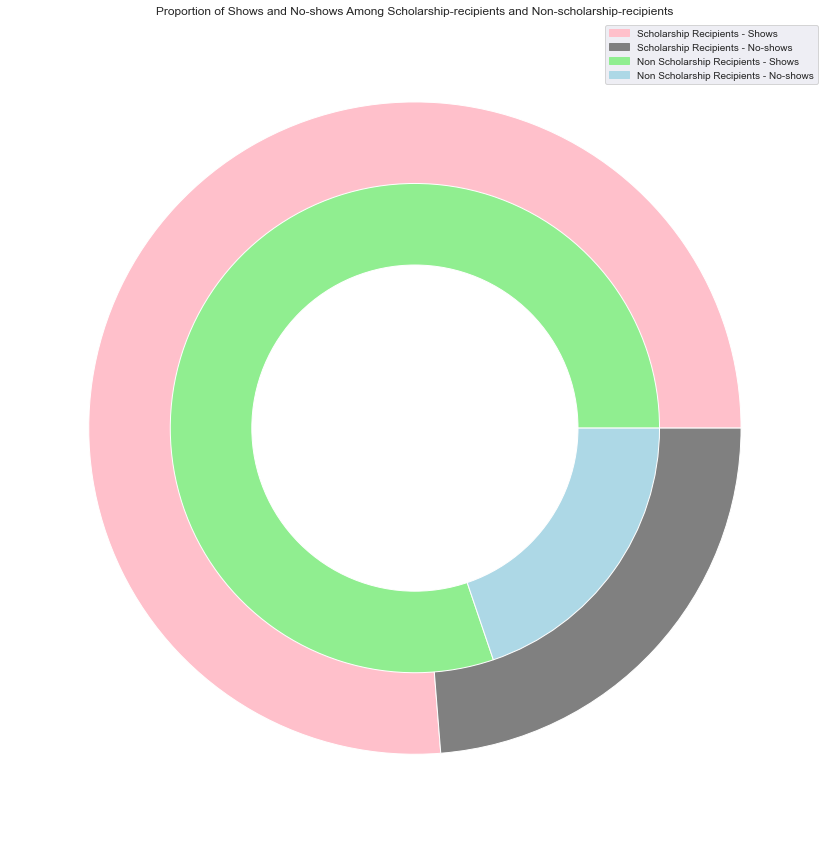

In [58]:
# scholarship-recipients
total_recipients = no_show_appointments_clean.query('scholarship == True').shape[0]
visited_recipients = no_show_appointments_clean[(no_show_appointments_clean.scholarship == True) & (no_show_appointments_clean.no_show == False)].shape[0]
other_recipients =  no_show_appointments_clean[(no_show_appointments_clean.scholarship == True) & (no_show_appointments_clean.no_show == True)].shape[0]
visited_recipients_prop = visited_recipients/total_recipients
other_recipients_prop = other_recipients/total_recipients

# non-scholarship-recipients
total_nonrecipients = no_show_appointments_clean.query('scholarship == False').shape[0]
visited_nonrecipients = no_show_appointments_clean[(no_show_appointments_clean.scholarship == False) & (no_show_appointments_clean.no_show == False)].shape[0]
other_nonrecipients =  no_show_appointments_clean[(no_show_appointments_clean.scholarship == False) & (no_show_appointments_clean.no_show == True)].shape[0]
visited_nonrecipients_prop = visited_nonrecipients/total_nonrecipients
other_nonrecipients_prop = other_nonrecipients/total_nonrecipients

plt.figure(figsize=(15,15))
plt.pie([visited_recipients_prop, other_recipients_prop], colors=['pink', 'gray'],);
plt.pie([visited_nonrecipients_prop, other_nonrecipients_prop], labeldistance=-0.5, radius=0.75, colors=['lightgreen', 'lightblue']);
plt.title('Proportion of Shows and No-shows Among Scholarship-recipients and Non-scholarship-recipients')
circle = plt.Circle(xy=(0,0), radius=0.50, facecolor='white')
plt.gca().add_artist(circle);

v_recipients = mpatches.Patch(color='pink', label='Scholarship Recipients - Shows')
o_recipients = mpatches.Patch(color='gray', label='Scholarship Recipients - No-shows')
v_nonrecipients = mpatches.Patch(color='lightgreen', label='Non Scholarship Recipients - Shows')
o_nonrecipients = mpatches.Patch(color='lightblue', label='Non Scholarship Recipients - No-shows')

plt.legend(handles=[v_recipients, o_recipients, v_nonrecipients, o_nonrecipients], loc='upper right');

### Discussion
> By observing the chart above we can that the proportion of no-show patients increased among the recipients of the [Bolsa Familia Aid Program](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia). However, this increase is not a drastic one and therefore it cannot be proven that the two variables `scholarship` and `no_show` have an obvious correlation between them.

### How does alcohol consumption affect the number of no-shows in various medical centers?

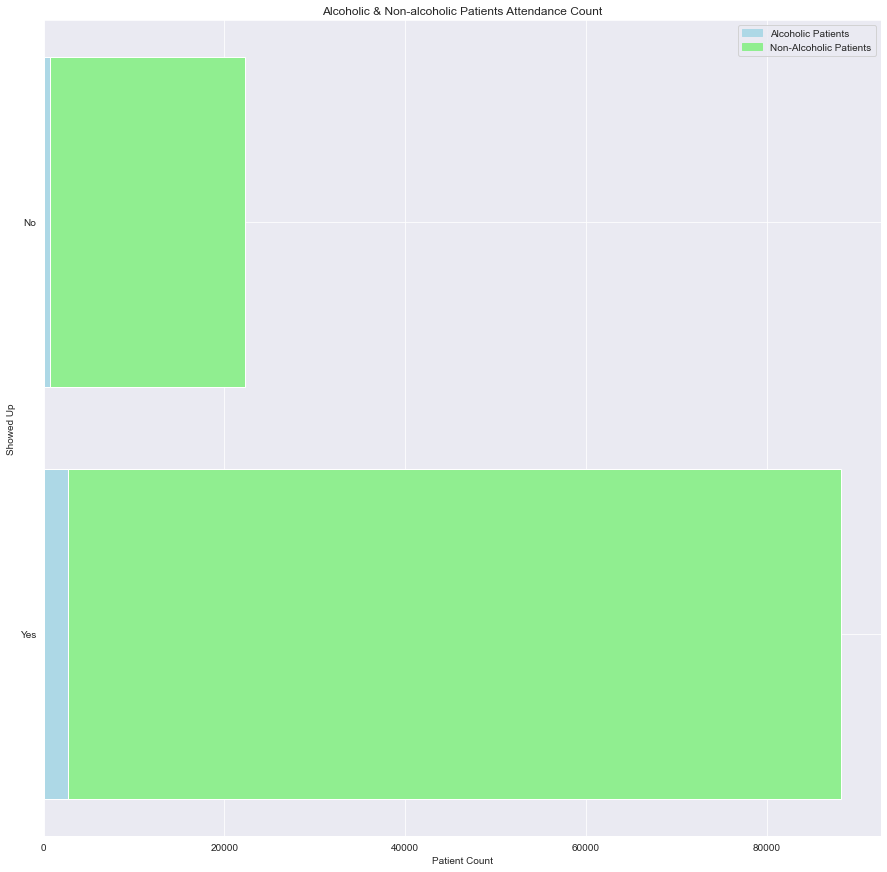

In [59]:
# alcoholics
visited_alcoholics = no_show_appointments_clean[(no_show_appointments_clean.alcoholism == True) & (no_show_appointments_clean.no_show == False)].shape[0]
other_alcoholics =  no_show_appointments_clean[(no_show_appointments_clean.alcoholism == True) & (no_show_appointments_clean.no_show == True)].shape[0]
alc_list = [visited_alcoholics, other_alcoholics]

# non-alcoholics
visited_clean = no_show_appointments_clean[(no_show_appointments_clean.alcoholism == False) & (no_show_appointments_clean.no_show == False)].shape[0]
other_clean =  no_show_appointments_clean[(no_show_appointments_clean.alcoholism == False) & (no_show_appointments_clean.no_show == True)].shape[0]
clean_list = [visited_clean, other_clean]

y = np.arange(len(alc_list))
plt.figure(figsize=(15,15))
plt.barh(y, alc_list, color='lightblue');
plt.barh(y, clean_list, color='lightgreen', left=alc_list);
y_labels = ['Yes', 'No']
plt.yticks(y, y_labels)
plt.xlabel('Patient Count')
plt.ylabel('Showed Up')
plt.title('Alcoholic & Non-alcoholic Patients Attendance Count')

alc_patch = mpatches.Patch(color='lightblue', label='Alcoholic Patients')
clean_patch = mpatches.Patch(color='lightgreen', label='Non-Alcoholic Patients')
plt.legend(handles=[alc_patch, clean_patch], loc='upper right');

In [60]:
print('Proportion of alcoholic show to no-show count: {}'.format(visited_alcoholics/other_alcoholics))
print('Proportion of non-alcoholic show to no-show count: {}'.format(visited_clean/other_clean))

Proportion of alcoholic show to no-show count: 3.9630723781388477
Proportion of non-alcoholic show to no-show count: 3.9526736608587143


### Discussion
> A very socially well-known trend is evident in the above bar chart; alcoholic patients are much less likely to abide by medical appointments than their non-alcoholic counterparts. Consequently, we can infer a positive correlation between the variables `alcoholism` and `no_show`, which means that alcoholic patients are expected to miss their appointments more often. However, this could be misleading as the total number of alcoholic patients in this dataset is much less than the number of non-alcoholic patients and it is worth mentioning that the proportion of show to no-show count for alcoholic as well as non-alcoholic patients is almost exactly the same. This could mean that the appointment drop-out rate is influenced by other factors.

<a id='conclusions'></a>
## Conclusions

For brevity, in this investigation of the no-show-appointments dataset, it was found that:
- Difference in time between registration dates and appointment date did not have a significant impact on indication whether a patient will show up to his/her medical appointment.
- Scholarship recipients are almost as likely to attend their medical appointments as their counterparts without scholarships.
- A positive correlation may exist between both `alcoholism` and `no_show` variables but this dataset is lacking in alcoholic patients' data to fully prove this speculation.

## Limitations
There were 2 major limitations in this dataset that may have negatively influenced the inferences made by looking at the data.
1. The abscence of the time component from all entries under `appointment_day` may undermine the credibility of the first visualization, which used the waiting time that was derived as `appointment_day` - `scheduled_day` where the column `scheduled_day` did have a time component.
2. The information available in the 3rd visualization may have also been negatively impacted by the fact that the total number of alcoholic patients in the dataset was much less than that of the non-alcoholic patients. Therefore, a sample that represented the Brazilian population better could have been chosen to make it easier to derive accurate conclusions from the data. A comparison between the total number of alcoholics and non-alcoholics in Brazil in 2016 can be found [here](https://www.who.int/substance_abuse/publications/global_alcohol_report/profiles/bra.pdf?ua=1).